# Distillation Debugging

In [1]:
from data_distillation.models.transformer.feature_extractors.triplet_cross_attention_vit import TripletCrossAttentionViT as TCAiT
from data_distillation.models.transformer.feature_extractors.tcait_extractor import TCAiTExtractor
from data_distillation.models.transformer.feature_extractors.pyramid.pyra_tcait import PyraTCAiT
from data_distillation.models.transformer.feature_extractors.pyramid.pyramid_vision_transformer import PyramidVisionTransformer as PVT

from data_distillation.losses.triplet_losses.triplet_classification_loss import TripletClassificationLoss as TCLoss
from data_distillation.losses.triplet_losses.triplet_loss import TripletLoss

from data_distillation.optimization.schedulers.warmup_cosine_scheduler import WarmupCosineScheduler

from data_distillation.testing.data.test_triplets import TestTriplets
from data_distillation.testing.data.triplets import Triplets
from data_distillation.data_distiller import DataDistiller

from torch.utils.data.dataloader import DataLoader

import torch.optim as optim
import torch.nn as nn
import torch

from torchvision.transforms import Compose, Resize, RandomResizedCrop, CenterCrop, RandomHorizontalFlip, ColorJitter, Normalize, Lambda

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/home/hice1/cclark339/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 

## Test and debug TCAiT model

In [2]:
EMBED_DIM = 512
NUM_CLASSES = 21841
NUM_EXTRACTOR_HEADS = 8
NUM_CLASSIFIER_HEADS = 8
BATCH_SIZE = 16
IMG_CHANNELS = 3
IMG_DIM = 224
USE_MINIPATCH = False

In [3]:
# test initialization

model = TCAiT(embed_dim=EMBED_DIM, num_classes=NUM_CLASSES, num_extractor_heads=NUM_EXTRACTOR_HEADS, num_classifier_heads=NUM_CLASSIFIER_HEADS, in_channels=IMG_CHANNELS, in_dim=IMG_DIM, extractor_use_minipatch=USE_MINIPATCH)

In [4]:
# test forward function

anchor = torch.rand(BATCH_SIZE, IMG_CHANNELS, IMG_DIM, IMG_DIM)
positive = torch.rand(BATCH_SIZE, IMG_CHANNELS, IMG_DIM, IMG_DIM)
negative = torch.rand(BATCH_SIZE, IMG_CHANNELS, IMG_DIM, IMG_DIM)

In [5]:
if torch.cuda.is_available():
    anchor = anchor.cuda()
    positive = positive.cuda()
    negative = negative.cuda()

    model = model.cuda()

In [6]:
z_anchor, z_positive, z_negative, Y = model(anchor, positive, negative)

In [7]:
# test string function

print(model)

Extractor
Name                                                                   | Params       | Size                
--------------------------------------------------------------------------------------------------------------
patcher.patch_conv.weight                                              |       393216 | (512, 3, 16, 16)    
patcher.patch_conv.bias                                                |          512 | (512,)              
anchor_cls_tokenizer.cls_tokens                                        |          512 | (1, 1, 512)         
positive_cls_tokenizer.cls_tokens                                      |          512 | (1, 1, 512)         
negative_cls_tokenizer.cls_tokens                                      |          512 | (1, 1, 512)         
anchor_pos_encoder.pos_embedding                                       |       100864 | (1, 197, 512)       
positive_pos_encoder.pos_embedding                                     |       100864 | (1, 197, 512)       
negativ

## Test and debug PyraTCAiT model

In [8]:
EMBED_DIMS = [64, 128, 320, 512]
HEAD_COUNTS = [1, 2, 5, 8]
MLP_RATIOS = [8, 8, 4, 4]
SR_RATIOS = [8, 4, 2, 1]
DEPTHS = [3, 3, 6, 3]
ADD_CLASSIFIER = True
NUM_CLASSES = 2

In [9]:
# test initialization

model = PyraTCAiT(embed_dims=EMBED_DIMS, head_counts=HEAD_COUNTS, mlp_ratios=MLP_RATIOS, sr_ratios=SR_RATIOS, depths=DEPTHS,
                  add_classifier=ADD_CLASSIFIER, num_classes=NUM_CLASSES)

In [10]:
BATCH_SIZE = 16
IMG_CHANNELS = 3
IMG_DIM = 224

In [11]:
# test forward function

anchor = torch.rand(BATCH_SIZE, IMG_CHANNELS, IMG_DIM, IMG_DIM)
positive = torch.rand(BATCH_SIZE, IMG_CHANNELS, IMG_DIM, IMG_DIM)
negative = torch.rand(BATCH_SIZE, IMG_CHANNELS, IMG_DIM, IMG_DIM)

In [12]:
if torch.cuda.is_available():
    anchor = anchor.cuda()
    positive = positive.cuda()
    negative = negative.cuda()

    model = model.cuda()

In [13]:
z_anchor, z_positive, z_negative, Y = model(anchor, positive, negative)

In [14]:
# test string function

print(model)

Stage 0
Name                                                                   | Params       | Size                
--------------------------------------------------------------------------------------------------------------
patcher.patch_conv.weight                                              |         3072 | (64, 3, 4, 4)       
patcher.patch_conv.bias                                                |           64 | (64,)               
patcher.norm.weight                                                    |           64 | (64,)               
patcher.norm.bias                                                      |           64 | (64,)               
anchor_pos_encoder.pos_embedding                                       |       200704 | (1, 3136, 64)       
positive_pos_encoder.pos_embedding                                     |       200704 | (1, 3136, 64)       
negative_pos_encoder.pos_embedding                                     |       200704 | (1, 3136, 64)       
transform

## Test DataDistiller object

In [15]:
EMBED_DIM = 128
NUM_CLASSES = 2
NUM_EXTRACTOR_HEADS = 2
NUM_CLASSIFIER_HEADS = 2
BATCH_SIZE = 16
NUM_TRAIN_BATCHES = 4
NUM_VALID_BATCHES = 1
IMG_CHANNELS = 3
IMG_DIM = 224
EXTRACTOR_DEPTH = 4
EXTRACTOR_MLP_RATIO = 2.0
CLASSIFIER_DEPTH = 1
CLASSIFIER_MLP_RATIO = 2.0
USE_MINIPATCH = False

NUM_EPOCHS = 5
CHECKPOINTS_DIR = '/Users/charlieclark/Documents/GATech/OMSCS/CichlidBowerTracking/cichlid_bower_tracking/data_distillation/models/testing_weights'
DEVICE = 'cpu'
GPU_ID = -1

In [16]:
# setup simple T-CAiT model
model = TCAiT(embed_dim=EMBED_DIM, num_classes=NUM_CLASSES, num_extractor_heads=NUM_EXTRACTOR_HEADS, num_classifier_heads=NUM_CLASSIFIER_HEADS, in_channels=IMG_CHANNELS, in_dim=IMG_DIM, \
              extractor_depth=EXTRACTOR_DEPTH, extractor_mlp_ratio=EXTRACTOR_MLP_RATIO, classifier_depth=CLASSIFIER_DEPTH, classifier_mlp_ratio=CLASSIFIER_MLP_RATIO, extractor_use_minipatch=USE_MINIPATCH)

print(model)

Extractor
Name                                                                   | Params       | Size                
--------------------------------------------------------------------------------------------------------------
patcher.patch_conv.weight                                              |        98304 | (128, 3, 16, 16)    
patcher.patch_conv.bias                                                |          128 | (128,)              
anchor_cls_tokenizer.cls_tokens                                        |          128 | (1, 1, 128)         
positive_cls_tokenizer.cls_tokens                                      |          128 | (1, 1, 128)         
negative_cls_tokenizer.cls_tokens                                      |          128 | (1, 1, 128)         
anchor_pos_encoder.pos_embedding                                       |        25216 | (1, 197, 128)       
positive_pos_encoder.pos_embedding                                     |        25216 | (1, 197, 128)       
negativ

In [17]:
# setup datasets and dataloaders
train_dataset = TestTriplets(batch_size=BATCH_SIZE, num_batches=NUM_TRAIN_BATCHES, num_channels=IMG_CHANNELS, dim=IMG_DIM)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

valid_dataset = TestTriplets(batch_size=BATCH_SIZE, num_batches=NUM_VALID_BATCHES, num_channels=IMG_CHANNELS, dim=IMG_DIM)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)

In [18]:
len(valid_dataset)

300

In [19]:
# setup optimizer
optimizer = optim.Adam(model.parameters())

In [20]:
# setup loss function
loss_fn = TCLoss()

In [21]:
# set up datadistiller
distiller = DataDistiller(train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, nepochs=NUM_EPOCHS, nclasses=NUM_CLASSES, checkpoints_dir=CHECKPOINTS_DIR,device=DEVICE, gpu_id=GPU_ID)

In [22]:
# perform training/validation
distiller.main_loop()


---------------------------------------------------------------------------------------------
EPOCH [0/5]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:05<00:00,  3.52it/s, accuracy=0.439, loss=5.91]


Epoch 0 Checkpoint Saved!

---------------------------------------------------------------------------------------------
EPOCH [1/5]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:05<00:00,  3.51it/s, accuracy=0.479, loss=1.59]


Epoch 1 Checkpoint Saved!

---------------------------------------------------------------------------------------------
EPOCH [2/5]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:05<00:00,  3.47it/s, accuracy=0.491, loss=0.946]


Epoch 2 Checkpoint Saved!

---------------------------------------------------------------------------------------------
EPOCH [3/5]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:05<00:00,  3.20it/s, accuracy=0.464, loss=1.06] 


Epoch 3 Checkpoint Saved!

---------------------------------------------------------------------------------------------
EPOCH [4/5]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:05<00:00,  3.36it/s, accuracy=0.462, loss=0.939]

Epoch 4 Checkpoint Saved!


In [23]:
EMBED_DIMS = [12, 24, 48, 96]
HEAD_COUNTS = [1, 2, 4, 6]
MLP_RATIOS = [4, 4, 2, 2]
SR_RATIOS = [8, 4, 2, 1]
DEPTHS = [1, 2, 4, 2]
ADD_CLASSIFIER = True
NUM_CLASSES = 2
INIT_ALPHA = 0.1
INIT_BETA = 0.1
USE_IMPROVED = True

NUM_EPOCHS = 2
CHECKPOINTS_DIR = '/Users/charlieclark/Documents/GATech/OMSCS/CichlidBowerTracking/cichlid_bower_tracking/data_distillation/models/testing_weights'
DEVICE = 'cpu'
GPU_ID = '-1'

In [24]:
# setup simple PyraT-CAiT model
model = PyraTCAiT(embed_dims=EMBED_DIMS, head_counts=HEAD_COUNTS, mlp_ratios=MLP_RATIOS, sr_ratios=SR_RATIOS, depths=DEPTHS,
                  add_classifier=ADD_CLASSIFIER, num_classes=NUM_CLASSES, init_alpha=INIT_ALPHA, init_beta=INIT_BETA, use_improved=USE_IMPROVED)

print(model)

Stage 0
Name                                                                   | Params       | Size                
--------------------------------------------------------------------------------------------------------------
patcher.patch_conv.weight                                              |          576 | (12, 3, 4, 4)       
patcher.patch_conv.bias                                                |           12 | (12,)               
patcher.norm.weight                                                    |           12 | (12,)               
patcher.norm.bias                                                      |           12 | (12,)               
anchor_pos_encoder.pos_embedding                                       |        37632 | (1, 3136, 12)       
positive_pos_encoder.pos_embedding                                     |        37632 | (1, 3136, 12)       
negative_pos_encoder.pos_embedding                                     |        37632 | (1, 3136, 12)       
tca_block

In [25]:
# setup datasets and dataloaders
train_dataset = TestTriplets(batch_size=BATCH_SIZE, num_batches=NUM_TRAIN_BATCHES, num_channels=IMG_CHANNELS, dim=IMG_DIM)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)

valid_dataset = TestTriplets(batch_size=BATCH_SIZE, num_batches=NUM_VALID_BATCHES, num_channels=IMG_CHANNELS, dim=IMG_DIM)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)

In [26]:
len(valid_dataset)

300

In [27]:
# setup optimizer
optimizer = optim.Adam(model.parameters())

In [28]:
# setup loss function
loss_fn = TCLoss() if ADD_CLASSIFIER else TripletLoss()

In [29]:
# set up datadistiller
distiller = DataDistiller(train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, nepochs=NUM_EPOCHS, nclasses=NUM_CLASSES, checkpoints_dir=CHECKPOINTS_DIR, device=DEVICE, gpu_id=GPU_ID)

In [31]:
# perform training/validation
distiller.main_loop()


---------------------------------------------------------------------------------------------
EPOCH [0/2]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:28<00:00,  1.49s/it, accuracy=0.465, loss=0.699]


Epoch 0 Checkpoint Saved!

---------------------------------------------------------------------------------------------
EPOCH [1/2]
---------------------------------------------------------------------------------------------


Validation, Batch [18/19]: 100%|██████████| 19/19 [00:27<00:00,  1.47s/it, accuracy=0.492, loss=0.696]

Epoch 1 Checkpoint Saved!


# Experiments

In [2]:
# dataset paths
DATASET_PATH = '/home/hice1/cclark339/scratch/Data/ImageNet-1K/imagenet1k-triplets.csv'

# data splitting args
NUM_CLASSES = 5
RANDOM_STATE = 42
TEST_SIZE = 0.1
SHUFFLE = True

# data augmentation args
TRAIN_DIM = 224
VALID_DIM = 256

BRIGHTNESS = 0.4
CONTRAST = 0.4
SATURATION = 0.4
HUE = 0.1

NORM_MEANS = [0.485, 0.456, 0.406]
NORM_STDS = [0.229, 0.224, 0.225]

# setup args
BATCH_SIZE = 16
CHANNELS = 3
NUM_EPOCHS = 10
CHECKPOINTS_DIR = '/home/hice1/cclark339/scratch/Checkpoints/Experimentation/'
DEVICE = 'gpu'
GPU_ID = 0
START_EPOCH = 0
USE_DDP = False
DISABLE_PROGRESS_BAR = False

# model args
EMBED_DIMS = [64, 128, 320, 512]
HEAD_COUNTS = [1, 2, 5, 8]
MLP_RATIOS = [8, 8, 4, 4]
SR_RATIOS = [8, 4, 2, 1]
DEPTHS = [3, 3, 6, 3]
PATCH_SIZE = 4
NUM_STAGES = 4
DROPOUT = 0.1
USE_IMPROVED = True
CLASSIFICATION_INTENT = False
ADD_CLASSIFIER = True

# optimizer and scheduler args
USE_LABEL_SMOOTHING = False
LEARNING_RATE = 1e-4
BETAS = [0.9, 0.999]
WEIGHT_DECAY = 2.5e-4
PATIENCE = 10
WARMUP_EPOCHS = 3
ETA_MIN = 0.0

# PVT args
NAME = 'pvt_v2_b2'
DROP_RATE = 0.0
PRETRAINED = False

In [3]:
df = pd.read_csv(DATASET_PATH)
df = df[df['label'] < NUM_CLASSES]

df.head()

,anchor,positive,negative,label
18,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,3
291,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,4
321,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,2
450,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,3
641,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,/home/hice1/cclark339/scratch/Data/ImageNet-1K...,0


In [4]:
train_transform = [
    Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
    RandomResizedCrop(TRAIN_DIM),
    RandomHorizontalFlip(),
    ColorJitter(BRIGHTNESS, CONTRAST, SATURATION, HUE),
    Normalize(NORM_MEANS, NORM_STDS)
]

valid_transform = [
    Lambda(lambda img: img.repeat(3, 1, 1) if img.shape[0] == 1 else img),
    Resize(VALID_DIM),
    CenterCrop(TRAIN_DIM),
    Normalize(NORM_MEANS, NORM_STDS)
]

In [5]:
train_df, valid_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=SHUFFLE)
del df

train_dataset = Triplets(train_df, transform=Compose(train_transform))
valid_dataset = Triplets(valid_df, transform=Compose(valid_transform))

In [6]:
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE)

In [7]:
# PyraT-CAiT
# model = PyraTCAiT(embed_dims=EMBED_DIMS, head_counts=HEAD_COUNTS, mlp_ratios=MLP_RATIOS, sr_ratios=SR_RATIOS, depths=DEPTHS,
#                   num_stages=NUM_STAGES, dropout=DROPOUT, first_patch_dim=PATCH_SIZE, in_channels=CHANNELS, in_dim=TRAIN_DIM, 
#                   add_classifier=ADD_CLASSIFIER, use_improved=USE_IMPROVED, classification_intent=CLASSIFICATION_INTENT, num_classes=NUM_CLASSES)

# PVT
model = PVT(name=NAME, num_classes=NUM_CLASSES, embed_dim=EMBED_DIMS[-1], drop_rate=DROP_RATE, pretrained=PRETRAINED)

In [8]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, betas=tuple(BETAS), weight_decay=WEIGHT_DECAY)
scheduler = WarmupCosineScheduler(optimizer=optimizer, warmup_epochs=WARMUP_EPOCHS, total_epochs=NUM_EPOCHS, eta_min=ETA_MIN)

In [9]:
loss_fn = TCLoss(use_label_smoothing=USE_LABEL_SMOOTHING)

In [10]:
distiller = DataDistiller(train_dataloader=train_dataloader, valid_dataloader=valid_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, scheduler=scheduler, nepochs=NUM_EPOCHS, 
                          nclasses=NUM_CLASSES, checkpoints_dir=CHECKPOINTS_DIR, device=DEVICE, gpu_id=GPU_ID, start_epoch=START_EPOCH, ddp=USE_DDP, disable_progress_bar=DISABLE_PROGRESS_BAR)

In [11]:
distiller.main_loop()


---------------------------------------------------------------------------------------------
EPOCH [0/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:42<00:00,  1.04s/it, accuracy=0.205, loss=2.82]


Epoch 0 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [1/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.21it/s, accuracy=0.358, loss=2.49]


Epoch 1 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [2/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:10<00:00,  4.09it/s, accuracy=0.231, loss=2.45]


Epoch 2 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [3/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.13it/s, accuracy=0.374, loss=2.34]


Epoch 3 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [4/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.14it/s, accuracy=0.229, loss=2.51]


Epoch 4 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [5/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.21it/s, accuracy=0.22, loss=2.61] 


Epoch 5 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [6/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.20it/s, accuracy=0.23, loss=2.61] 


Epoch 6 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [7/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.20it/s, accuracy=0.275, loss=2.6] 


Epoch 7 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [8/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.20it/s, accuracy=0.368, loss=2.39]


Epoch 8 Checkpoint Saved!
Previous Epoch's Checkpoint Loaded!

---------------------------------------------------------------------------------------------
EPOCH [9/10]
---------------------------------------------------------------------------------------------


Validation, Batch [40/41]: 100%|██████████| 41/41 [00:09<00:00,  4.21it/s, accuracy=0.334, loss=2.3] 


Epoch 9 Checkpoint Saved!


In [12]:
train_avgs, train_mins, train_maxs = distiller.train_logger.avgs, distiller.train_logger.maxs, distiller.train_logger.mins
valid_avgs, valid_mins, valid_maxs = distiller.valid_logger.avgs, distiller.valid_logger.maxs, distiller.valid_logger.mins

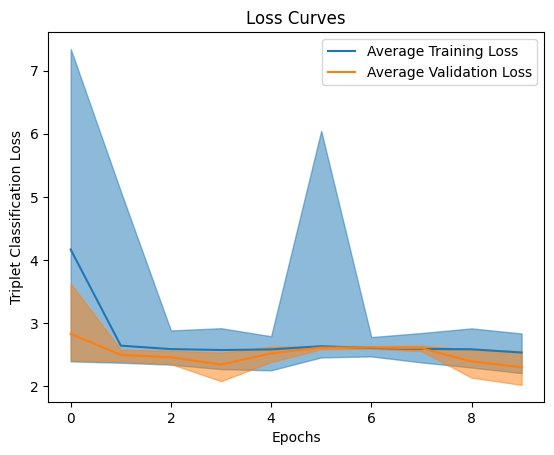

In [13]:
x = np.arange(0, NUM_EPOCHS)

plt.plot(x, train_avgs, label='Average Training Loss', color='tab:blue')
plt.fill_between(x, train_mins, train_maxs, color='tab:blue', alpha=0.5)

plt.plot(x, valid_avgs, label='Average Validation Loss', color='tab:orange')
plt.fill_between(x, valid_mins, valid_maxs, color='tab:orange', alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Triplet Classification Loss')
plt.title('Loss Curves')
plt.legend()

In [24]:
train_avgs, train_mins, train_maxs = distiller.acc_train_logger.avgs, distiller.acc_train_logger.maxs, distiller.acc_train_logger.mins
valid_avgs, valid_mins, valid_maxs = distiller.acc_valid_logger.avgs, distiller.acc_valid_logger.maxs, distiller.acc_valid_logger.mins

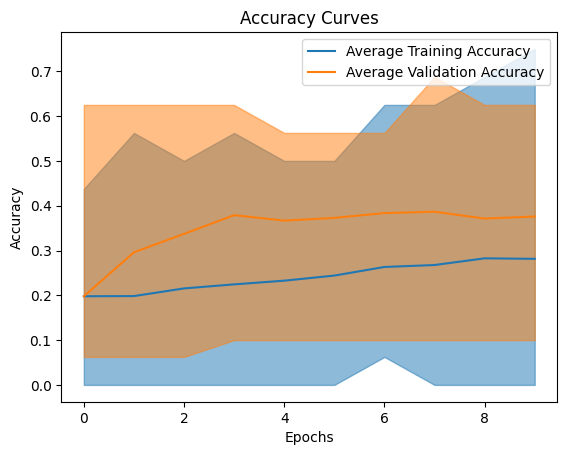

In [25]:
x = np.arange(0, NUM_EPOCHS)

plt.plot(x, train_avgs, label='Average Training Accuracy', color='tab:blue')
plt.fill_between(x, train_mins, train_maxs, color='tab:blue', alpha=0.5)

plt.plot(x, valid_avgs, label='Average Validation Accuracy', color='tab:orange')
plt.fill_between(x, valid_mins, valid_maxs, color='tab:orange', alpha=0.5)

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()